In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import seaborn as sns 

In [494]:
!pip install xlrd

In [0]:
import xlrd



In [0]:
#df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
#pdf = df
df= pd.read_excel("https://github.com/PriyadharshanSaba/OnlineRetailSales-RMFmodel/raw/master/Dataset/Online%20Retail.xlsx")


In [497]:
#DATA WRANGLING

#dropping NaN data rows
df=df.dropna()

#dropping description column
df=df.drop(columns=['Description'])
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df['Amount'] = df.UnitPrice * df.Quantity
#removing unit price
df=df.drop(columns=['UnitPrice'])

df['date'] = [d.date() for d in df['InvoiceDate']]
df['time'] = [d.time() for d in df['InvoiceDate']]
#print(df.head())


In [499]:
#CLEANING CUSTOMERS

#dropping NaN values in CustomerID
df = df[np.isfinite(df['CustomerID'])]      #df.loc[df['InvoiceNo']==573174]  reference for NaN value

#removing customers with less than 1Re of transaction
df=df[(df['Amount'] >=1)]
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Amount,date,time
0,536365,85123A,6,2010-12-01 08:26:00,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,8,2010-12-01 08:26:00,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


In [500]:
#grouping by countries and adding purchasing percentage on basis of quantity
group_country = df.groupby(['Country'],as_index=False).sum()
group_country = group_country.drop(columns=['CustomerID'])
group_country.sort_values('Quantity',ascending=False,inplace=True)

total_purchased = group_country['Quantity'].sum()
group_country['Buy_perc']=(group_country['Quantity']/total_purchased)*100
group_country.head()


,Country,Quantity,Amount,Buy_perc
35,United Kingdom,4239362,7.299319e+06,82.314544
23,Netherlands,200324,2.854209e+05,3.889637
10,EIRE,140275,2.655459e+05,2.723682
14,Germany,119249,2.288581e+05,2.315426
13,France,111414,2.089972e+05,2.163295


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



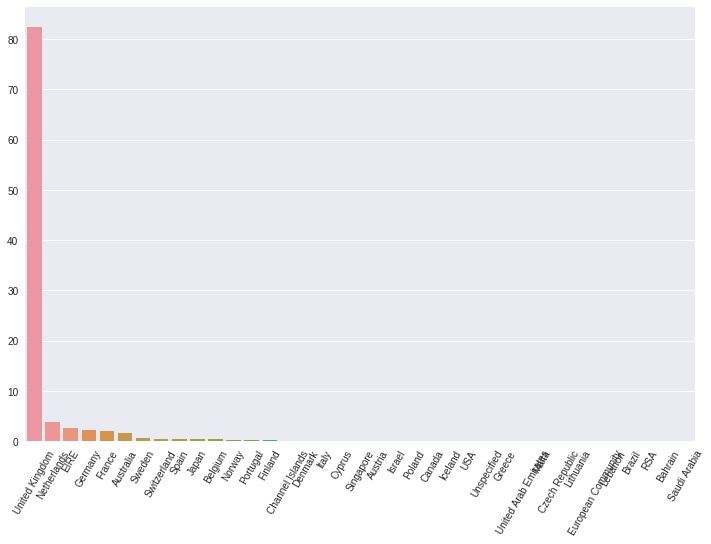

In [501]:
#Buy_Perc plotting

country=list(group_country['Country'])
Cust_id=list(group_country['Buy_perc'])
plt.figure(figsize=(12,8))
sns.barplot(country, Cust_id, alpha=1)
plt.xticks(rotation='60')
plt.show()


In [0]:
#analysing country with highest purchasing 
x=group_country.where(group_country['Buy_perc']==group_country['Buy_perc'].max())
x=x['Country'].dropna().get_values().tolist()[0]

dfcur = df.where(df.Country == x)
dfcur=dfcur.dropna()

In [503]:
#first time buyers
x=dfcur.groupby('CustomerID',).count()
no_customers= x['InvoiceNo'].count()
no_first_timers=x.where(x['InvoiceNo']==1).dropna().count()['InvoiceNo']
print('Percentage of new customers purchasing for the first time',(no_first_timers*100/no_customers))



Percentage of new customers purchasing for the first time 1.7857142857142858


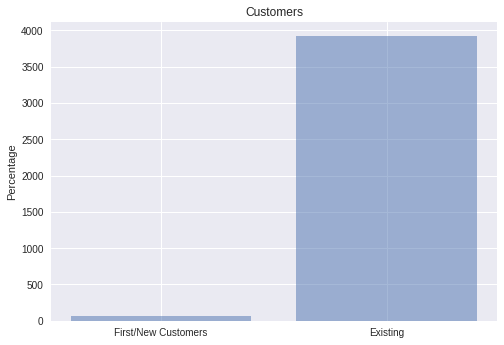

In [504]:
objects = ('First/New Customers', 'Existing')
y_pos = np.arange(len(objects))
perc = [no_first_timers,no_customers]
plt.bar(y_pos, perc, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('Customers')
 
plt.show()

In [0]:
#Converting to date to shortened string formate %y(2)%m
dfcur['dateS']=dfcur['date'].apply(lambda x: x.strftime('%y%m'))
#print('Far date: ',dfcur['dateS'].min(),"\tRecent: ",dfcur['dateS'].max())

In [0]:
#RMF MODEL

#---- Recency Analysis------
def recency(row):
  if int(row['dateS']) > 1109:
    val = 5
  elif int(row['dateS']) <= 1109 and int(row['dateS']) > 1106:
    val = 4
  elif int(row['dateS']) <= 1106 and int(row['dateS']) > 1103:
    val = 3
  elif int(row['dateS']) <= 1103 and int(row['dateS']) > 1101:
    val = 2
  else:
    val = 1
  return val
  
dfcur['Recency_val'] = dfcur.apply(recency, axis=1)

In [507]:
dfcur.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Amount,date,time,dateS,Recency_val
0,536365,85123A,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,15.30,2010-12-01,08:26:00,1012,1
1,536365,71053,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1
2,536365,84406B,8.0,2010-12-01 08:26:00,17850.0,United Kingdom,22.00,2010-12-01,08:26:00,1012,1
3,536365,84029G,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1
4,536365,84029E,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1


In [508]:
#table with just recency values
rec_df = dfcur
rec_df = rec_df.drop(columns=['Quantity','InvoiceNo','StockCode','InvoiceDate','Country','Amount','date','time','dateS'])
recencyTable = rec_df.drop_duplicates( keep=False)
rec_df.head()

,CustomerID,Recency_val
0,17850.0,1
1,17850.0,1
2,17850.0,1
3,17850.0,1
4,17850.0,1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



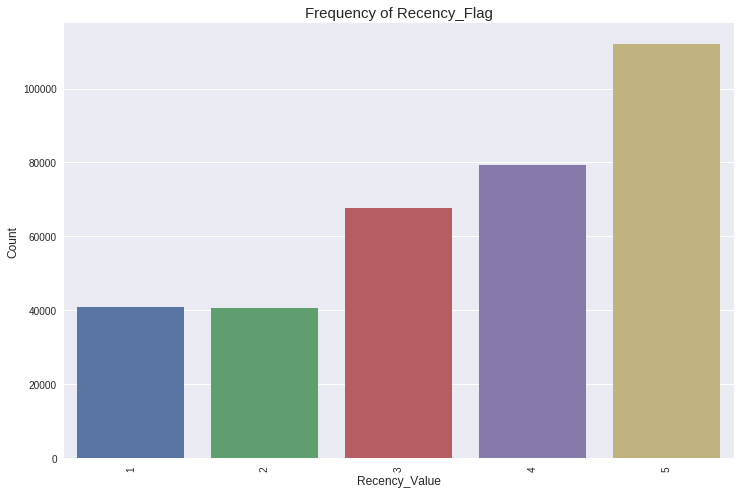

In [509]:
plt.figure(figsize=(12,8))
sns.countplot(x="Recency_val", data=rec_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Recency_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Recency_Flag", fontsize=15)
plt.show()

In [510]:
print("\tRecency Analysis\n",rec_df.groupby('Recency_val',as_index=False).count())




	Recency Analysis
    Recency_val  CustomerID
0            1       40931
1            2       40635
2            3       67785
3            4       79400
4            5      112059


In [565]:
#------Frequency Analysis-------

freq_df = dfcur[['Country','InvoiceNo','CustomerID']].drop_duplicates()
freq_count = freq_df.groupby(['Country','CustomerID'],as_index=False)[['InvoiceNo']].count()
freq_count.head()

,Country,CustomerID,InvoiceNo
0,United Kingdom,12346.0,1
1,United Kingdom,12747.0,11
2,United Kingdom,12748.0,207
3,United Kingdom,12749.0,5
4,United Kingdom,12820.0,4


In [566]:
unique_invoice=freq_df[['InvoiceNo']].drop_duplicates()
unique_invoice.head()

,InvoiceNo
0,536365
7,536366
9,536367
21,536368
25,536369


In [567]:
#Dividing the dataframe into 5 bands
unique_invoice['fband']=pd.qcut(unique_invoice['InvoiceNo'],5)
unique_invoice.head()
freqBandTable = unique_invoice[['fband']].drop_duplicates().reset_index()
freqBandTable

,index,fband
0,0,"(536364.999, 546000.2]"
1,113904,"(546000.2, 555005.8]"
2,207810,"(555005.8, 564094.4]"
3,309586,"(564094.4, 573101.6]"
4,422644,"(573101.6, 581586.0]"


In [568]:
def frequ(row):
  if row['InvoiceNo'] <= 13:
    val = 1
  elif row['InvoiceNo'] > 13 and row['InvoiceNo']<=24:
    val =2
  elif row['InvoiceNo']>24 and row['InvoiceNo']<=35:
    val = 3
  elif row['InvoiceNo']>35 and row['InvoiceNo']<=60:
    val = 4
  else:
    val = 5
  return val

freq_count['freq_val'] = freq_count.apply(frequ,axis=1)
freq_count.head()

,Country,CustomerID,InvoiceNo,freq_val
0,United Kingdom,12346.0,1,1
1,United Kingdom,12747.0,11,1
2,United Kingdom,12748.0,207,5
3,United Kingdom,12749.0,5,1
4,United Kingdom,12820.0,4,1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



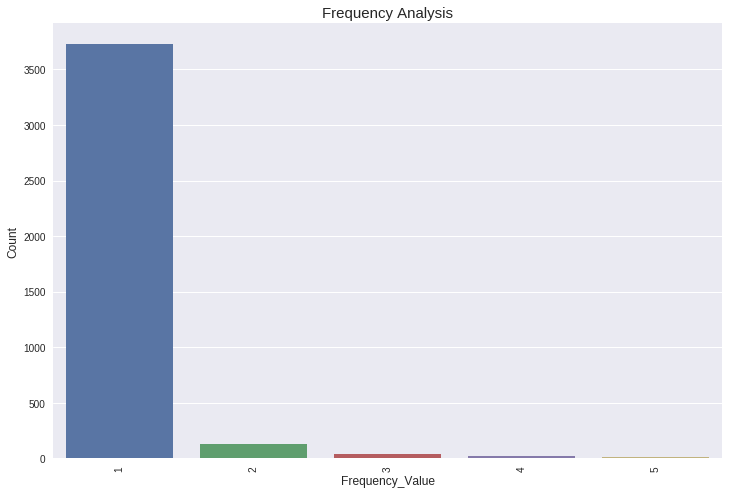

In [569]:
plt.figure(figsize=(12,8))
sns.countplot(x="freq_val", data=freq_count)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Frequency_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency Analysis", fontsize=15)
plt.show()

In [570]:
print("\tFrequency Analysis\n",freq_count.groupby('freq_val',as_index=False).count())




	Frequency Analysis
    freq_val  Country  CustomerID  InvoiceNo
0         1     3729        3729       3729
1         2      127         127        127
2         3       37          37         37
3         4       19          19         19
4         5        8           8          8


In [571]:
#----MonetaryValue Analysis------

#monetary value for each country
monetary_df_countries = df.groupby(['Country','CustomerID'],as_index=False)['Amount'].sum()
monetary_df_countries.head()

,Country,CustomerID,Amount
0,Australia,12386.0,401.90
1,Australia,12388.0,2780.66
2,Australia,12393.0,1582.60
3,Australia,12415.0,124910.63
4,Australia,12422.0,386.20


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



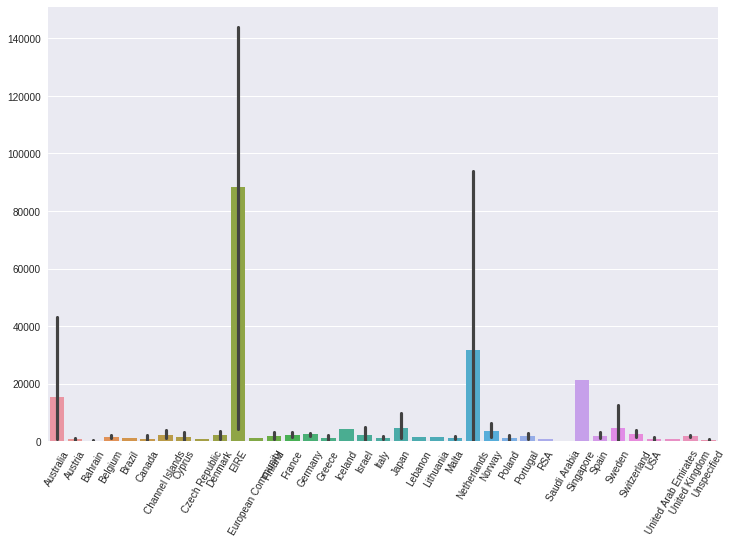

In [572]:
ctry=list(monetary_df_countries['Country'])
amt=list(monetary_df_countries['Amount'])
plt.figure(figsize=(12,8))
sns.barplot(ctry, amt, alpha=1)
plt.xticks(rotation='60')
plt.show()

In [573]:
print("\tMonetary Analysis Countrywise\n",monetary_df_countries.groupby('Country',as_index=False)[['Amount']].sum().sort_values('Amount', ascending=False).reset_index(drop=True).head())

	Monetary Analysis Countrywise
           Country      Amount
0  United Kingdom  7299318.66
1     Netherlands   285420.87
2            EIRE   265545.90
3         Germany   228858.07
4          France   208997.21


In [625]:
#getting monetary band
monprice_df = dfcur[['CustomerID','Amount']].drop_duplicates()
monprice_df = monprice_df.groupby(['CustomerID'])[['Amount']].sum()
monprice_df['monetary'] = pd.qcut(monprice_df['Amount'],5)
monprice_df=monprice_df.sort_values(by=['monetary'])
monetary_band = monprice_df[['monetary']].drop_duplicates().reset_index(drop=True)
monetary_band

,monetary
0,"(3.749, 171.38]"
1,"(171.38, 306.886]"
2,"(306.886, 511.26]"
3,"(511.26, 955.366]"
4,"(955.366, 168472.5]"


In [629]:
x=monetary_band['monetary'].get_values().tolist()
x

[Interval(3.749, 171.38, closed='right'),
 Interval(171.38, 306.886, closed='right'),
 Interval(306.886, 511.26, closed='right'),
 Interval(511.26, 955.366, closed='right'),
 Interval(955.366, 168472.5, closed='right')]

In [632]:
def mon(row):
  if row['Amount'] <= x[0].right:
    val = 1
  elif row['Amount']> x[0].right and row['Amount']<=x[1].right:
    val = 2
  elif row['Amount']> x[1].right and row['Amount']<=x[2].right:
    val = 3
  elif row['Amount']> x[2].right and row['Amount']<=x[3].right:
    val = 4
  else:
    val = 5
  return val

monprice_df['Mont_val'] = price_df.apply(mon,axis=1)

monprice_df.head()


,Amount,monetary,Mont_val
CustomerID,,,
14598.0,146.04,"(3.749, 171.38]",NaN
14821.0,48.80,"(3.749, 171.38]",1.0
17536.0,25.50,"(3.749, 171.38]",NaN
17984.0,104.23,"(3.749, 171.38]",NaN
14823.0,142.05,"(3.749, 171.38]",NaN


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



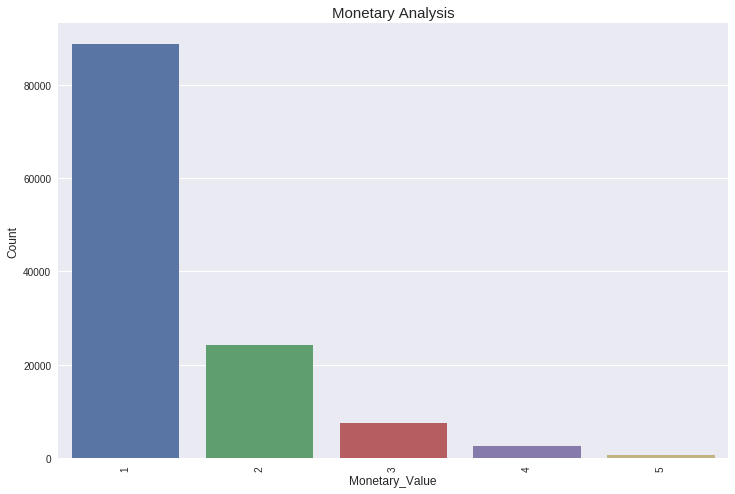

In [593]:
plt.figure(figsize=(12,8))
sns.countplot(x="Mont_val", data=price_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Monetary_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monetary Analysis", fontsize=15)
plt.show()

In [577]:
print("\tMonetary Analysis\n",price_df.groupby(['Mont_val'],as_index=False)['monetary'].count())

	Monetary Analysis
    Mont_val  monetary
0         1       620
1         2       496
2         3       529
3         4       554
4         5       544


In [578]:
rec_df.head()

,CustomerID,Recency_val
0,17850.0,1
1,17850.0,1
2,17850.0,1
3,17850.0,1
4,17850.0,1


In [579]:
freq_count.head()

,Country,CustomerID,InvoiceNo,freq_val
0,United Kingdom,12346.0,1,1
1,United Kingdom,12747.0,11,1
2,United Kingdom,12748.0,207,5
3,United Kingdom,12749.0,5,1
4,United Kingdom,12820.0,4,1


In [590]:
uk_df=pd.merge(rec_df,freq_count,price_df)


ValueError: ignored